In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy

SEED = 42
np.random.seed(SEED)

In [2]:
def French_DeGroot(x, P, n_iterations):
    '''Simulates French DeGroot model x(t+1) = P'x(t)'''
    for iteration in range(n_iterations):
        x = P@x
    return x


def simulate_continous_MC(P, w, starting_position, ending_position, n_simulations, n_nodes, return_position = 0):
    '''simulate a continous MC with node clocks w_i and times defined as -ln(u)/w_i when in node i;
    going from starting_position ending in ending_position'''
    
    #define structure to store the transition times and the positions during simulation
    transition_times = []
    position = np.zeros(n_nodes)
    
    for simulation in range(n_simulations):
        current_node = starting_position 
        simulation_time = 0
        
        #simulation
        while True:
            
            if current_node == ending_position and simulation_time > 0:
                break
            
            #define the time to wait for the transition
            t_next = -np.log(np.random.rand())/w[current_node]

            #jump to next node according to Q 
            next_node = np.random.choice(n_nodes, p= P[current_node, :])

            #update simulation time
            simulation_time += t_next
            
            #update the node for the next iteration and save hit
            current_node = next_node
            position[current_node] +=1
        
        transition_times.append(simulation_time)
        
    if return_position:
        return transition_times, position

    return transition_times

def update_clock_proportional(system, w, n_nodes):
    '''Computes new transition times according to the proportional strategy in exercise 3'''
    clock = np.zeros(n_nodes)
    #set clock for o'
    clock[0] += -np.log(np.random.rand())
    #set clock for d if particles are present
    if system[n_nodes-1] >0:
        clock[n_nodes-1] += -np.log(np.random.rand())/(2*system[n_nodes-1])
    #set clock for all other nodes
    for n in range(1, n_nodes-1):
        if system[n]>0:
            clock[n] += -np.log(np.random.rand())/(w[n]*system[n])
    return clock

def update_clock_fixed(system, w, n_nodes):
    '''Computes new transition times according to the fixed strategy in exercise 3'''
    clock = np.zeros(n_nodes)
    #set clock for o'
    clock[0] += -np.log(np.random.rand())
    #set clock for d if particles are present
    if system[n_nodes-1] >0:
        clock[n_nodes-1] += -np.log(np.random.rand())/2
    #set clock for all other nodes
    for n in range(1, n_nodes-1):
        if system[n]>0:
            clock[n] += -np.log(np.random.rand())/w[n]
    return clock

def find_min_clock(clock):
    '''retruns the index of the non-zero fastest clock'''
    return min([(index, time) for index, time in enumerate(clock) if time >0], key = lambda x: x[1])[0]

# EXERCISE

Is Graph strongly connected? True
Is Graph aperiodic? True


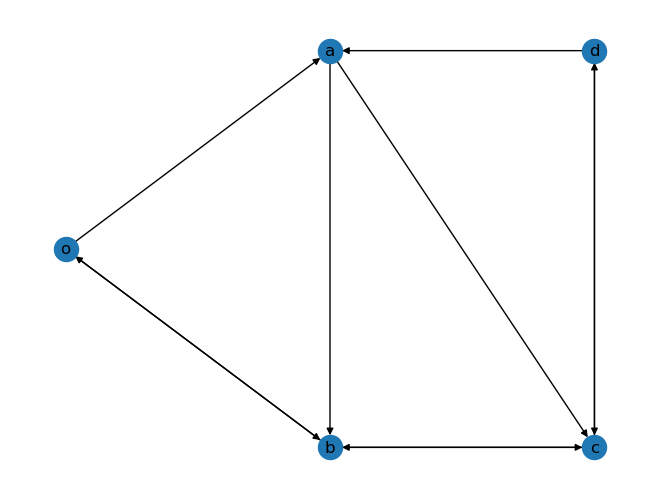

In [3]:
G = nx.DiGraph()
edge_list = [('o', 'b'), ('b', 'o'), ('o', 'a'), ('a', 'b'), ('b','c'), 
         ('c', 'b'), ('a', 'c'), ('c', 'd'), ('d', 'c'), ('d', 'a')]
G.add_edges_from(edge_list)
pos = {'o': (0,0), 'b': (1, -1), 'a': (1, 1), 'd': (2,1), 'c':(2,-1)}

nx.draw(G, pos, with_labels = True )

#Some useful graph prooperties
print(f"Is Graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Is Graph aperiodic? {nx.is_aperiodic(G)}")

In [4]:
#transition matrix with columns and row order (o, a, b, c, d)
Lambda = np.array([[0, 2/5, 1/5, 0, 0], [0, 0, 3/4, 1/4, 0], [1/2, 0, 0, 1/2, 0], 
        [0, 0, 1/3, 0, 2/3], [0, 1/3, 0, 1/3, 0]])

NODES = len(Lambda)

**What is, according to the simulations, the average time it takes a particle that starts in node $a$ to leave the node and then return to it?** \
A continous MC is simulated using a clock rate for every node $w_i$.  
We assume that the time between two clock ticks can be modelled as follows:

$t_{next} = - \frac{ln(u)}{w_i}$ where $ u \sim \mathcal{U}(0,1) $

and the probability for to jump from node $i$ to node $j$ in modelled by $P_{ij}$.

The average times it takes to reach node $a$ when we start from node $a$ for 1000 simulations is computed. 

In [5]:
#define w and P = diag(w)^(-1) Lambda
w = np.sum(Lambda, axis=1)
P = np.diag(1/w) @ Lambda 

#simulate the Markow chain
transition_times = simulate_continous_MC(P, w, 1, 1, 1000, NODES)

In [6]:
expected_return = np.mean(transition_times)
print(f"Expected return time from node A is {expected_return:.2f}")

Expected return time from node A is 6.66


**How does the result in a) compare to the theoretical return-time $\mathbb{E}_a[T_a^+]$ \?** \
Theorem: Let $X(t)$ be a continous time Markow Chain with finite state space $\mathcal{X}$ and transition matrix $\Lambda$. Let $G_{\Lambda} = (\mathcal{X}, \mathcal{E}, \Lambda)$ strongly connected, then:
- There exists an unique Laplace invariant probability distribution $\bar{\pi}$ 
- The expected return times satify
    $E_i[\bar{T_i^+}] = \frac{1}{\omega_i\bar{\pi_i}} i \in \mathcal(X)$ \
  where $\bar{T_i^+}$ = inf{ t$\leq$0: X(t) = i and X(s) $\neq$ i for some s $\in$ (0,t)}

$\bar{\pi}$ is a stationary probability vector satisfying $L'\bar{\pi}= 0$ and $\mathbb{1}'\bar{\pi} = 1$.

Note that $\bar{\pi}$ is different from the stationary probability distribution $\pi$ and it is related to it through the following formula:
$\bar{\pi_i} = \frac{\pi_i/w_i}{\sum_j \pi_j/w_j}$

In [7]:
#find pi
eigenvalues, eigenvectors = np.linalg.eig(P.T)
index = np.argmax(eigenvalues.real)
pi = eigenvectors[:, index].real
pi = pi/sum(pi)

#compute pi_bar
pi_bar = (pi/w) / np.sum(pi/w) 

#compute expected time for node A
expected_a = 1/(w[1]* pi_bar[1])
print(f"Expected return time for node A is {expected_a:.2f}")

Expected return time for node A is 6.75


**What is, according to the simulations, the average time it takes to move from node $o$ to node $d$?** 

A continous MC is simulated using a single clock rate $w^* = max_i(w_i)$ for the network. 
We assume that the time between two clock ticks can be modelled as follows:

$t_{next} = - \frac{ln(u)}{w^*}$ where $ u \sim \mathcal{U}(0,1) $

Hence, given the matrix Q, when the clock ticks at step $i$: either we move to state $ j \neq i$ with probability $Q_{ij} = \frac{\Lambda_{ij}}{w^*}$ or we stay in node $i$ with probability $Q_{ii} = 1- \sum_{i\neq j} Q_{ij}$

The average times it takes to reach node $o$ when we start from node $d$ for 1000 simulations is computed. 

In [8]:
#perform simulation: from node 0 ('o') to node 4 ('d') for 1000 times
transition_times = simulate_continous_MC(P, w, 0, 4, 1000, NODES)

expected_hitting_simulation = np.mean(transition_times)
print(f"Expected hitting time from node O to node D with simulation is {expected_hitting_simulation:.2f}")

Expected hitting time from node O to node D with simulation is 8.34


**How does the result in c) compare to the theoretical hitting-time $\mathbb{E}_o[T_d]$? (Describe also how
this is computed)**

In order to find the hitting-times of a subset of nodes S, the following linear system of equations must be solved:\
- $\mathbb{E}_i[T_S] = 0$,  if $i \in S $
- $\mathbb{E}_i[T_S] = \frac{1}{\omega_i} + \sum_{j \in \mathcal{X}} P_{ij}\mathbb{E}_j[T_S]$, if $i \not\in S $

In our case, the subset S is only composed by node $d$.  

In [9]:
#compute left hand operand of linear system of equations (I-P)*E[T_s] = 1/w_i
P_left = (np.identity(NODES) - P)[:-1, :-1]

inverse_w = 1/w

expected_hitting = np.linalg.solve(P_left, inverse_w[:-1])
print(f"Expected theorical hitting time from node O to node D is {expected_hitting[0]:.2f}")


Expected theorical hitting time from node O to node D is 8.79


**Interpret the matrix $\Lambda$ as the weight matrix of a graph $G = (\mathcal{V}, \varepsilon, \Lambda) $, and simulate the French DeGroot dynamics on $G$ with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state for every initial condition $x(0)$? Motivate your answer**

If the Graph has a single sink compinent and such a component is aperiodic, then we have convergence to a consensus:
$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

In our case G is strongly connected (single connected component) and aperiodic, hence all nodes should converge to the same opinion in the long run.

In [10]:
#number iterations for the French DeGroot model
n_iterations = 100

#number of times the French DeGroot model is run
n_runs = 1000

In [11]:
#general initial condition x(0) 
x_0 = np.random.choice([0,1], (NODES,))

#Run the French DeGroot model or enough times 
x = French_DeGroot(x_0, P, n_iterations)
print(f"Consensus after {n_iterations} is {x}")

Consensus after 100 is [0.43478261 0.43478261 0.43478261 0.43478261 0.43478261]


**Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = ξ_i$, where $ξ_i$ for $i \in \mathcal{V}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.** \
Given $G$ strongly connected and aperiodic, we want to estimate a quantity $\mu$ and we run the French DeGroot model on an initial condition $x_i(0) = \mu + ξ_i$, hence we compute $x(t+1) = P^tx(0)$. 
In the long run $x(t) \rightarrow \bar{x}$, where
$\bar{x} = \sum_{k\in\mathcal{V}} \pi_kx_k(0) = \mu + \sum_{k\in\mathcal{v}} \pi_kξ_k $

With the following estimates: \
$\mathbb{E}[\bar{x}] = \mu $ \
$\mathbb{V}[\bar{x}] = \sigma^2 \sum_{k\in\mathcal{V}}\pi_k^2$ 

where $\pi$ is the unique invariant probability distribution of $G$. 


In [12]:
#general initial condition x(0) = ξ_i, hence we want to estimate mu = 0 
sigma = math.sqrt(2)

consensus = []

#Simulate the French DeGroot model for 
for run in range(n_runs):
    x_0 = np.random.normal(scale = sigma, size =(NODES,)) 
    #contruct the initial condition according to a normal distribution centered in 0 and having standard deviation sigma.
    x = French_DeGroot(x_0, P, n_iterations)
    consensus.append(x[0])
    
    
print(f"Consensus after {n_iterations} is {x}")
print(f"Variance after {n_runs} simulations is {np.var(consensus):.2f}")

Consensus after 100 is [-0.59561999 -0.59561999 -0.59561999 -0.59561999 -0.59561999]
Variance after 1000 simulations is 0.43


In [13]:
#theorical variance 
eigenvalues, eigenvectors = np.linalg.eig(P.T)
index = np.argmax(eigenvalues.real)
pi = eigenvectors[:, index].real
pi  = pi/sum(pi)

variance = sigma**2 * sum([p**2 for p in pi])
print(f"Theorical variance is {variance:.2f}")
print(f"Invariant distribution centraility is {pi}")

Theorical variance is 0.43
Invariant distribution centraility is [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]


**Remove the edges $(d, a)$ and $(d, c)$. Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$? Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = ξ_i$, where $ξ_i$ $i \in \mathcal{V}$ are i.i.d random variables with variance $\sigma = 2$. Compute the variance of the consensus value. Motivate your answer.**
D is a stubborn node since it is a trapping node. Consequently, he won't change his initial opinion. All other nodes, instead, are strongly connected and they look at node $d$, therefore they will change their opinion and converge to the $d$'s one hence to $x_d(0)$. \
Given that there is a single sink component in the condensation graph $H_G$, the unique probability distribution $\pi$ is supported on the nodes of the sink component. which in our case corresponds to node $d$: $\pi = (0,0,0,0,1)$. \
Therefore, the variance of the consensus value is: 
$\mathbb{V}[\bar{x}] = \sigma^2 \sum_{k\in\mathcal{V}}\pi_k^2 = \sigma^2 * \pi_d^2 = 2$ 


In [14]:
#Update Lambda according to the new graph
Lambda_g = deepcopy(Lambda)
Lambda_g[4][1] = 0
Lambda_g[4][3] = 0

#adding self loop to avoid dividing by 0 
Lambda_g[4][4] = 1 

inverse_w = 1/np.sum(Lambda_g, axis = 1)

#compute new P
P = np.diag(inverse_w) @ Lambda_g

In [15]:
#compute invariant probability distribution
eigenvalues, eigenvectors = np.linalg.eig(P.T)
index = np.argmax(eigenvalues.real)
pi = eigenvectors[:, index].real
pi  = pi/sum(pi)

#compute theoretical variance
variance = sigma**2 * sum([p**2 for p in pi])
print(f"Theorical variance is {variance:.2f}")
print(f"Invariant distribution centrality is {pi}")

Theorical variance is 2.00
Invariant distribution centrality is [0. 0. 0. 0. 1.]


**Consider $G(\mathcal{V}, \varepsilon, \Lambda)$, and remove the edges $(c, b)$ and $(d, a)$. Analyse the French DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition $x(0)$.** \
There is a connected component made of nodes $(o,b,a)$ and another sink component made of nodes $(d,c)$; $\pi$ is now supported on $c$ and $d$: $\pi=(0,0,0,.5,.5)$. 
We already mentioned that (assuming aperiodicity and a single sink component in $H_G$): \
$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$
Where $\alpha = \pi'x(0)$. 

In conclusion, the asymptotic limit is now the average of the initial opinions of $d$ and $c$.

In [16]:
#Update Lambda according to new graph
Lambda_h = deepcopy(Lambda)
Lambda_h[4][1] = 0
Lambda_h[3][2] = 0

#compute new P
inverse_w = 1/np.sum(Lambda_h, axis = 1)
P = np.diag(inverse_w) @Lambda_h

In [17]:
#compute invariant probability distribution
eigenvalues, eigenvectors = np.linalg.eig(P.T)
index = np.argmax(eigenvalues.real)
pi = eigenvectors[:, index].real
pi  = pi/sum(pi)

In [18]:
#general initial condition x(0) = ξ_i
sigma = math.sqrt(2)
x_0 = np.random.normal(scale = sigma, size =(NODES,)) 
print(f"Initial distribution is {x_0}")

#Show that the average of the initial conditions of d and c equals the consensus limit value alpha
average_dc = np.mean(x_0[3:])
print(f"Average of the initial condition of nodes d and c is {average_dc:.2f}")

print(f"Alpha is {x_0 @ pi:.2f}")

Initial distribution is [ 1.84262138  0.86333637  1.53622755  0.63927851 -0.62053821]
Average of the initial condition of nodes d and c is 0.01
Alpha is 0.01


# EXERCISE

Simulation of multiple particles in the graph according to a continous time MC.

PARTICLE PERSPECTIVE: attach a Poisson clock to each particle and move them individually. Each particle stays in node $i$ on average $\frac{1}{\omega_i}$ time units and moves then to a next node according to the probability matrix $P = diag(\omega)^{-1}\Lambda$.

**If 100 particles all start in node $a$, what is the average time for a particle to return to node $a$?**


**How does this compare to the answer in Problem 1, why?**\
It is the same, since we are moving each particle independently from the others. Therefore the expected return time to $a$ is the same for every particle starting in $a$.  

In [19]:
#construct P
w = np.sum(Lambda, axis = 1)
P = np.diag(1/w) @ Lambda 

#set ending and starting position for each particle
starting_position = 1 
ending_position = 1

#set number of simulations to be perfromed for each particle
n_simulations = 100

#save transition times for each particle after simulation
particles_transition_times = []

#simulate continous MC for each particle individually using 1/w_i and P strategy 
for particle in range(100):
    transition_times = simulate_continous_MC(P, w, starting_position, ending_position, n_simulations, NODES)
    particles_transition_times.append(transition_times)

    
average_time = np.average(particles_transition_times)
print(f"Average time for a particle to return node a is {average_time:.2f}")

Average time for a particle to return node a is 6.78


SYSTEM PERSPECTIVE: observe particles from the node and care about the number of particles in each node.\
In node $i$ each particle will stay on average $\frac{1}{\omega_i}$ time units. Given that at time $t$ the number of particles in $i$ is $n_i(t)$, the departure times of the node can be seen as a Poisson Process with rate $n_i(t)\omega_i$ and at each tick of the Poisson clock of the node a paticle is moved to a neighbor, based on P.

A single system-wide Poisson clock with rate 100 and each tick we randomly select a node (according to the number of particles in the different nodes) from which we move a particle and move it according to the transition probability matrix $\bar{P}$ 

**If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?**

In [20]:
#construct P_bar 
rate = 100
w_star = max(w)

P_bar = Lambda/w_star + np.diag(np.ones(NODES) - np.sum(Lambda/w_star, axis = 1))

In [21]:
#initial situation: all particles are in node o 
system = np.zeros(NODES)
system[0] = 100

#to store the number of particles in the nodes at iteration i 
node_distribution = [deepcopy(system)]
network_rate = 100
t_start = 0
max_time = 60

cumulative_time = [t_start]

#simulation
while True:
    t_start += -np.log(np.random.rand())/network_rate
    #stopping condition
    if t_start > max_time:
        break
    #choose a node in which there are particles
    chosen_node = np.random.choice(NODES, p = system/np.sum(system))
    #choose a neighbor to move the particle to
    chosen_neighbor = np.random.choice(NODES, p= P_bar[chosen_node, :])
    #update the number of particles in the nodes
    system[chosen_node] -= 1
    system[chosen_neighbor] += 1
    #same current simulation time
    cumulative_time.append(t_start)
    #save current simulation 
    node_distribution.append(deepcopy(system))

    

In [22]:
print(f"Average number of particles at the end of the simulation is {np.mean(node_distribution, axis = 0)}, network_mean = {np.mean(node_distribution):.2f}")

Average number of particles at the end of the simulation is [19.97925515 14.60976805 21.77376674 21.87602091 21.76118915], network_mean = 20.00


**Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.**

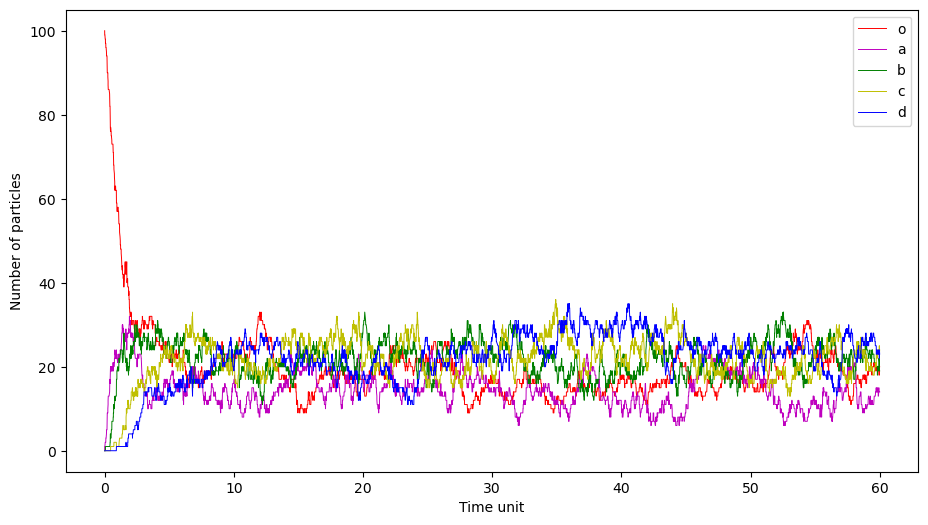

In [24]:
colors = ['r', 'm', 'g', 'y', 'b']
node_list = ['o', 'a', 'b', 'c', 'd']

fig, ax = plt.subplots(figsize = (11,6))

for node in range(NODES):
    plt.plot(cumulative_time, np.array(node_distribution).T[node], c = colors[node], linewidth = .7)

ax.set_xlabel('Time unit')
ax.set_ylabel('Number of particles')
ax.legend(node_list)
plt.show()

**Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles**

In [25]:
#compute the stationary distribution of the continous random walk followed by the single particles: pi_bar
eigenvalues, eigenvectors = np.linalg.eig(P_bar.T)
index = np.argmax(eigenvalues.real)
pi_bar = eigenvectors[:, index].real
pi_bar  = pi_bar/sum(pi_bar)

print(f"Stationary distribution of the continous random walk followed by a single particle is {pi_bar}")
print(f"Stationary distribution of the continous random walk followed by the single particles is {(pi_bar*100)}, and the network mean is {np.mean(pi_bar*100):.0f}")

Stationary distribution of the continous random walk followed by a single particle is [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
Stationary distribution of the continous random walk followed by the single particles is [18.51851852 14.81481481 22.22222222 22.22222222 22.22222222], and the network mean is 20


# EXERCISE

In [26]:
max_time = 60
#added node o' that can only send to node o and d has a self loop to avoid zero-division
Lambda = np.array([[0, 1, 0, 0, 0, 0], [0, 0, 3/4, 3/8, 0, 0], [0, 0, 0, 1/4, 1/4, 2/4], [0, 0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]])
NODES = Lambda.shape[0]
w = np.sum(Lambda, axis = 1)
P = np.diag(1/w) @ Lambda

PROPORTIONAL RATE: each node $i$ will pass along particles according to a Poisson process with rate equal to the number of paticles in the node times the rate of local Poisson clock of node $i$. Rate is $w_i*N_i(t)$ given the system perspective. 

In [27]:
#nodes are (o', o, a, b, c, d)
#starting a time random with a particle in node o' 
system = np.zeros(NODES)
#add a particle to o'
system[0] = 1

#at the first iteration it is mandatory to ent one particle from o' to o
clock = np.zeros(NODES)
clock[0] +=  -np.log(np.random.rand())
t_start = 0

node_distribution = [deepcopy(system)]
cumulative_time = [t_start]

while True:
    #choose the fastest clock
    node = find_min_clock(clock)
    #update the time 
    t_start += clock[node]
    #stopping condition
    if t_start > max_time:
        break
    #if node d is the fastest, then one particles exits the network
    if node == NODES-1:
        system[node] -= 1
    #if node o' is the fastest increment the content of node o -> one particle enters the network 
    elif node == 0:
        system[1] += 1
    #if any other node is the fastest, one particle moves to a neighbor
    else:
        neighbor = np.random.choice(range(1, NODES), p= P[node, 1:])
        system[node] -= 1
        system[neighbor] += 1
    #save current simulation 
    cumulative_time.append(t_start)
    node_distribution.append(deepcopy(system))
    #update the clocks
    clock = update_clock_proportional(system, w, NODES)

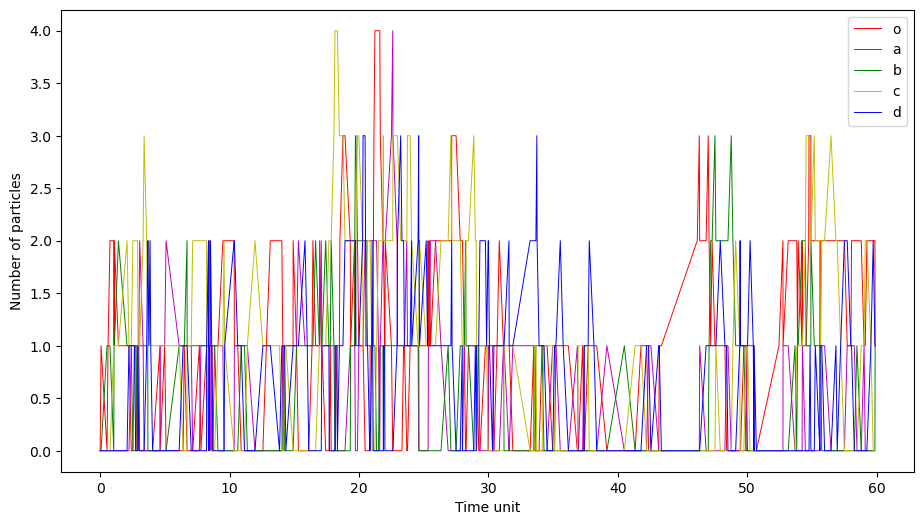

In [28]:
colors = ['r', 'm', 'g', 'y', 'b']
node_list = ['o', 'a', 'b', 'c', 'd']

fig, ax = plt.subplots(figsize = (11,6))

for node in range(1, NODES):
    plt.plot(cumulative_time, np.array(node_distribution).T[node], c = colors[node-1], linewidth = .7)

ax.set_xlabel('Time unit')
ax.set_ylabel('Number of particles')
ax.legend(node_list)
plt.show()

FIXED RATE: each node $i$ will pass along particles according to a Poisson process with rate equal to the local Poisson clock of node $i$. Rate is $w_i$ given the system perspective. 

In [30]:
#nodes are (o', o, a, b, c, d)
#starting a time random with a particle in node o' 
system = np.zeros(NODES)
#add a particle to o'
system[0] = 1

#at the first iteration it is mandatory to ent one particle from o' to o
clock = np.zeros(NODES)
clock[0] +=  -np.log(np.random.rand())
t_start = 0

node_distribution = [deepcopy(system)]
cumulative_time = [t_start]

while True:
    #choose the fastest clock
    node = find_min_clock(clock)
    #update the time 
    t_start += clock[node]
    #stopping condition
    if t_start > max_time:
        break
    #if node d is the fastest, then one particles exits the network
    if node == NODES-1:
        system[node] -= 1
    #if node o' is the fastest increment the content of node o -> one particle enters the network 
    elif node == 0:
        system[1] += 1
    #if any other node is the fastest, one particle moves to a neighbor
    else:
        neighbor = np.random.choice(range(1, NODES), p= P[node, 1:])
        system[node] -= 1
        system[neighbor] += 1
    #save current simulation 
    cumulative_time.append(t_start)
    node_distribution.append(deepcopy(system))
    #update the clocks
    clock = update_clock_fixed(system, w, NODES)

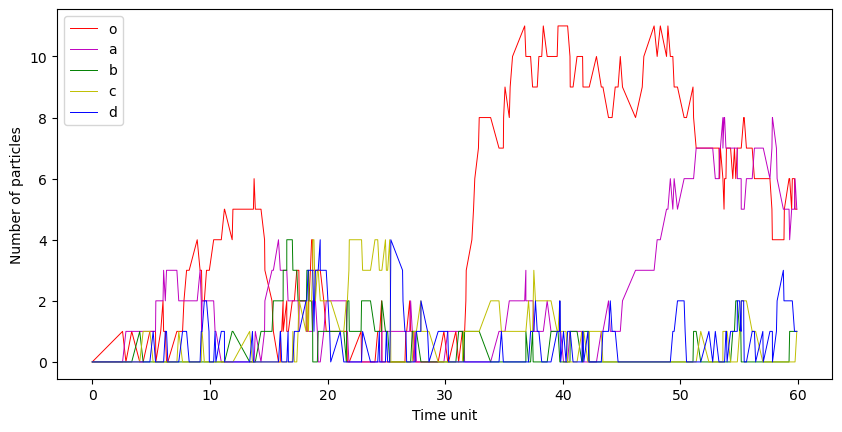

In [31]:
colors = ['r', 'm', 'g', 'y', 'b']
node_list = ['o', 'a', 'b', 'c', 'd']

fig, ax = plt.subplots(figsize = (10, 4.8))

for node in range(1, NODES):
    plt.plot(cumulative_time, np.array(node_distribution).T[node], c = colors[node-1], linewidth = .7)

ax.set_xlabel('Time unit')
ax.set_ylabel('Number of particles')
ax.legend(node_list)
plt.show()